In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import os
import glob
import re
import cv2
import math
from natsort import natsorted
from tqdm import tqdm
IMAGE_DATASETS = ['quickdraw', 'fashion']

In [2]:
dataset_id = ''

In [3]:
# dataset_id = 'cartolastd'
# os.chdir('..')

In [4]:
# !pwd

/home/eduardo/Desktop/Link to dynamic-projections


In [5]:
projection_paths = pd.read_csv('Metrics/results/{}.csv'.format(dataset_id), index_col=0).index
names = projection_paths.str.extract(r'.*/{}-(.*).csv'.format(dataset_id), expand=False) # Clean string

In [6]:
dataset_path = '../Datasets/' + dataset_id + '/'
print(projection_paths, dataset_id)

Index(['Output/cartolastd-AE_10f_10f_2f_50ep.csv',
       'Output/cartolastd-VAE_10f_10f_2f_100ep.csv',
       'Output/cartolastd-tsne_s1_30p.csv',
       'Output/cartolastd-tsne_s4_30p.csv',
       'Output/cartolastd-dtsne_100p_0-1l.csv',
       'Output/cartolastd-umap_s1_15p.csv',
       'Output/cartolastd-umap_s4_15p.csv', 'Output/cartolastd-pca_s1.csv',
       'Output/cartolastd-pca_s4.csv'],
      dtype='object') cartolastd


In [7]:
# !mkdir {'Plots/Anim/'+dataset_id}

In [8]:
def get_projection_as_array(dataset_path):
    df = pd.read_csv(dataset_path, index_col=0)
    vs = df.values.reshape(len(df), -1, 2)
    return vs, df.index, vs.shape[1]


def get_md_mov(dataset_path):
    vs, indexes, n_timesteps = get_projection_as_array(dataset_path)
    mov = []
    for poly in vs:
        mov_i = []
        for i in range(len(poly)-1):
            mov_i.append(math.sqrt(np.sum(np.square(poly[i] - poly[i+1]))))
        mov.append(np.array(mov_i))
    return np.array(mov), indexes, n_timesteps


# get_md_mov('./Output/quickdraw-pca_s4.csv')

In [9]:
def image_dataset_to_array(dataset_path):
    # Convert image to np array
    # Preload images to memory (trying to speed things up)
    all_files = glob.glob('{}*'.format(dataset_path))
    # Gather ids and timestep info    
    max_t = {}
    for f in all_files:
        regex = r".*/{}/(.*-.*)-(.*).png".format(dataset_id)
        match = re.match(regex, f)
        img_id, t = match.groups()
        t = int(t)
        max_t[img_id] = max_t[img_id] if img_id in max_t and max_t[img_id] > t else t   
    
    img_size = 28 * 28  # Pixel count
    n_revisions = max(max_t.values()) + 1
    n_items = len(max_t.values())
    vs = np.empty((n_revisions, n_items, img_size))
    
    # Populate vs
    for i, img_id in enumerate(natsorted(max_t)):
        # Copy existing bitmaps to np.array
        for t in range(0, max_t[img_id]):
            img_file = dataset_path + img_id + '-' + str(t) + '.png'
            vs[t][i] = (cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) / 255.).flatten()
        # Replicate last image
        for t in range(max_t[img_id], n_revisions):
            img_file = dataset_path + img_id + '-' + str(max_t[img_id]-1) + '.png'
            vs[t][i] = (cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) / 255.).flatten()    
    return vs, list(natsorted(max_t)), n_revisions


def tabular_dataset_to_array(dataset_path):
    # Get files with coords and save in an array vs
    all_files = natsorted(glob.glob('{}*'.format(dataset_path)))
    vs = [pd.read_csv(f, index_col=0).values for f in all_files] 
    # Get dataset info 
    df_temp = pd.read_csv(all_files[0], index_col=0)
    n_timesteps = len(all_files)
    return np.array(vs), list(df_temp.index), n_timesteps


def dataset_as_array(dataset_path):
    if dataset_id in IMAGE_DATASETS:
         return image_dataset_to_array(dataset_path)
    else:
        return tabular_dataset_to_array(dataset_path)


def get_nd_mov(dataset_id):
    mov = []
    dataset_path = './Datasets/' + dataset_id + '/'
    # Get the nd data into arrays
    vs, indexes, n_timesteps = dataset_as_array(dataset_path)
    # Compute dists between 2 nd arrays
    for t in range(n_timesteps - 1):
        v_t = vs[t]
        v_tp1 = vs[t+1]
        mov_t = []
        for a, b in zip(v_t, v_tp1):
            mov_t.append(math.sqrt(np.sum(np.square(a - b))))
        mov.append(np.array(mov_t)) 
    return np.array(mov).T, indexes, n_timesteps

# dists, indexes, n_timesteps = get_nd_dists('quickdraw')

In [10]:
lims = {}
pos_interp = {}
indexes = {}
colors = {}
for p_i, p in enumerate(projection_paths):
    pos, ind, n_timesteps = get_projection_as_array(p)
    # Shuffle arrays
    perm = np.random.permutation(len(ind))
    pos = pos[perm]
    indexes[p] = ind[perm]

    # Set x and y axis limits
    x_max = max(pos[:,:,0].flatten())
    x_min = min(pos[:,:,0].flatten())
    y_max = max(pos[:,:,1].flatten())
    y_min = min(pos[:,:,1].flatten())
    x_max = x_max + (x_max - x_min) * .03
    x_min = x_min - (x_max - x_min) * .03
    y_max = y_max + (y_max - y_min) * .03
    y_min = y_min - (y_max - y_min) * .03
    lims[p] = (x_min, x_max, y_min, y_max)

    # Choose colors
    colormap = matplotlib.cm.Set3
    classes = indexes[p].str.split('-').str[0]
    unique_colors = {k:i for i,k in enumerate(np.unique(classes))}
    colors[p] = [colormap(unique_colors[c]) for c in classes] 

    # Add more points with akima interpolation
    n_nans = 9
    pos_int = []
    for points in pos:
        extended = []
        for po in points:
            extended.append(list(po))
            for i in range(n_nans):
                extended.append([np.nan, np.nan])
        df = pd.DataFrame(extended)
        df = df.interpolate(method='akima')
        df = df.dropna()
        pos_int.append(df.values)
    pos_interp[p] = np.array(pos_int)
    n_extended = len(df)

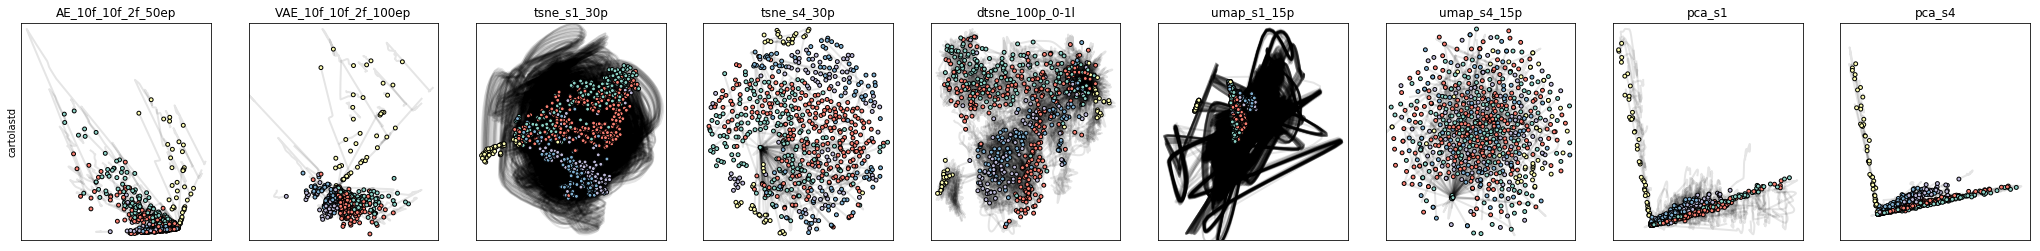

In [11]:
# anim_dir = 'Plots/Anim/{}'.format(dataset_id)
# Draw figures
n_proj = len(projection_paths)

t = n_extended - 1
fig_1, axes = plt.subplots(ncols=n_proj, nrows=1,figsize=(n_proj*4,4))

axes[0].set_ylabel(dataset_id)
for p_i, p in enumerate(projection_paths):
    # Draw trails
    ax = axes[p_i]
    ax.set_title(names[p_i])
    for i in range(len(indexes[p])):
        e_trail = t + 1
        points = pos_interp[p][i,:e_trail]
        ax.plot(points[:,0], points[:,1], 
                c='k', lw=2, alpha=.1);
    # Draw scatter
    ax.scatter(pos_interp[p][:,t,0], pos_interp[p][:,t,1], 
               edgecolors='#000000', s=15, c=colors[p], alpha=1, zorder=4);

    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                   labelbottom=False, right=False, left=False, labelleft=False)
    ax.set_xlim(lims[p][0], lims[p][1])
    ax.set_ylim(lims[p][2], lims[p][3])
#     break
    plt.axis('equal')

# Save current frame
#     plt.savefig('{}/proj-{}.png'.format(anim_dir, t),
#                 format='png', dpi=80, bbox_inches='tight')
plt.show()
# plt.clf()
# plt.close()
fig_1.savefig('fig_1.png', bbox_inches='tight', pad_inches=0.1)

In [12]:
from scipy.stats import rankdata
# Compute distances
mov_nd, indexes, n_timesteps = get_nd_mov(dataset_id)
mov_md_dict = {}
for p in projection_paths:
    mov, _, _ = get_md_mov(p)
    mov_md_dict[p] = mov

# Flatten the data
mov_nd = mov_nd.flatten()
diffs = {}
max_diff = 0
min_diff = 0
for p in projection_paths:
    mov_md = mov_md_dict[p].flatten()
    md_rank = rankdata(mov_md)
    nd_rank = rankdata(mov_nd)
    diffs[p] = abs(md_rank - nd_rank)
    max_diff = max(diffs[p]) if max(diffs[p]) > max_diff else max_diff
    min_diff = min(diffs[p]) if min(diffs[p]) < min_diff else min_diff

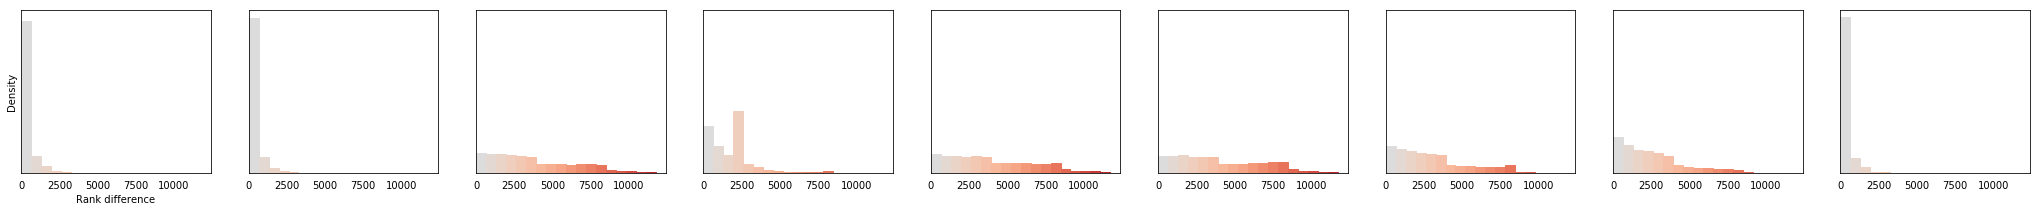

In [13]:
fig_2, axes = plt.subplots(ncols=len(projection_paths), nrows=1, sharey=True, sharex=True, figsize=(len(projection_paths)*4, 3))
axes = axes.flatten()
n_bins = 19
bins = np.linspace(min_diff, max_diff, n_bins+1)
axes[0].set_xlim((0, max_diff))
axes[0].set_ylabel(' ')
for i, p in enumerate(projection_paths):
    ax = axes[i]
    if i == 0:
        ax.set_xlabel('Rank difference')
        ax.set_ylabel('Density')
        
    n, _, patches = ax.hist(diffs[p], bins=bins, density=1)    
    bin_avgs = [(a+b)/2 for a, b in zip(bins, bins[1:])]
#     norm = Normalize(vmin=min_diff, vmax=max_diff)
    cs = cm.coolwarm(np.linspace(0.5,1,n_bins))
    [p.set_color(c) for p, c in zip(patches,cs)]
    
    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                   labelbottom=True, right=False, left=False, labelleft=False)
fig_2.savefig('fig_2.png', bbox_inches='tight', pad_inches=0.1)

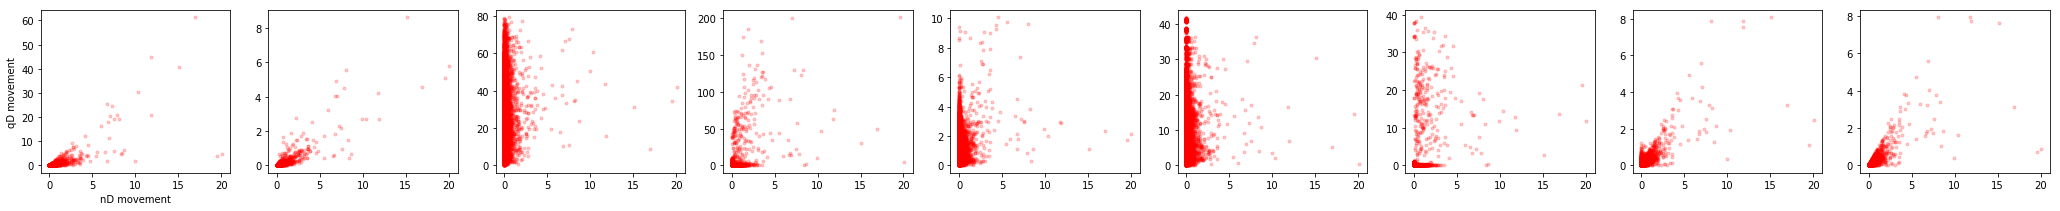

In [14]:
fig_3, axes = plt.subplots(ncols=len(projection_paths), nrows=1, figsize=(len(projection_paths)*4, 3))
axes = axes.flatten()

# Compute distances
mov_nd, indexes, n_timesteps = get_nd_mov(dataset_id)
mov_md_dict = {}
for p in projection_paths:
    mov, _, _ = get_md_mov(p)
    mov_md_dict[p] = mov


mov_nd = mov_nd.flatten()
for i, p in enumerate(projection_paths):
    ax = axes[i]
    if i == 0:
        ax.set_xlabel('nD movement')
        ax.set_ylabel('qD movement')
        
    mov_md = mov_md_dict[p].flatten()
    axes[i].plot(mov_nd, mov_md, 'ro', alpha=.2, markersize=3)

fig_3.savefig('fig_3.png', bbox_inches='tight', pad_inches=0.1)

100%|██████████| 19/19 [00:02<00:00,  6.86it/s]


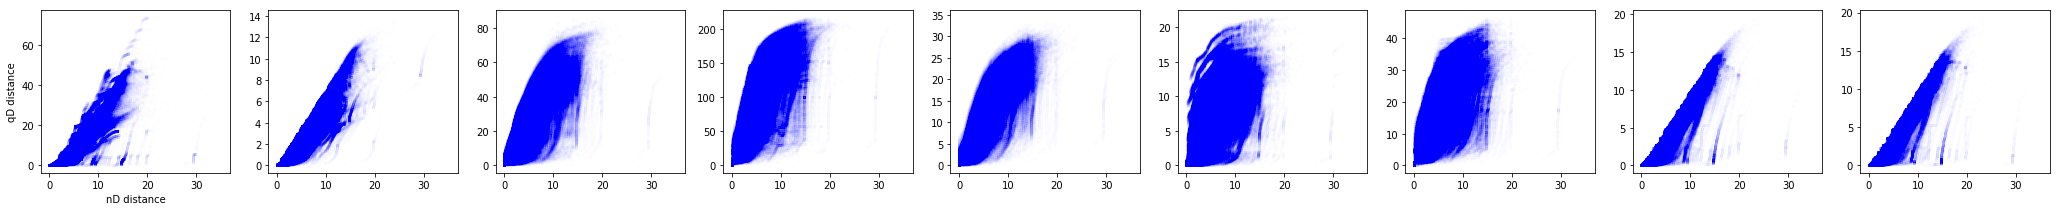

In [15]:
from sklearn.neighbors import NearestNeighbors

fig_4, axes = plt.subplots(ncols=len(projection_paths), nrows=1, figsize=(len(projection_paths)*4, 3))
axes = axes.flatten()

dataset_path = './Datasets/' + dataset_id + '/'
vs_n, indexes, n_revisions = dataset_as_array(dataset_path)

mov_nd = mov_nd.flatten()
for i, p in enumerate(projection_paths):
    # Change axis in projection
    vs_m, _, _ = get_projection_as_array(p)
    
    vs_m = np.transpose(vs_m, (1,0,2))
    
    # Initialize structures
    dists_nd_all = []
    dists_md_all = [] 
    
    for t in tqdm(range(n_timesteps)):
        # Generate list of nearest neighbors for each item in timestep t
        dists_nd, nbrs_nd = NearestNeighbors(n_neighbors=len(indexes), metric='euclidean',
                                      algorithm='ball_tree').fit(vs_n[t]).kneighbors(vs_n[t])   
        dists_md, nbrs_md = NearestNeighbors(n_neighbors=len(indexes), metric='euclidean',
                                      algorithm='kd_tree').fit(vs_m[t]).kneighbors(vs_m[t])
        
        # Save distances to compute correlation/stress metrics
#         dists_nd = np.delete(dists_nd, 0)
        dists_nd_all.append(dists_nd)
#         dists_md = np.delete(dists_md, 0)
        dists_md_all.append(dists_md)
    
    dists_nd_all = np.array(dists_nd_all)
    dists_md_all = np.array(dists_md_all)
    dists_nd_all = dists_nd_all.flatten()
    dists_md_all = dists_md_all.flatten()
    
    ax = axes[i]
    if i == 0:
        ax.set_xlabel('nD distance')
        ax.set_ylabel('qD distance')
        
    mov_md = mov_md_dict[p].flatten()
    axes[i].plot(dists_nd_all, dists_md_all, 'bo', alpha=.002, markersize=3, markevery=10)

fig_4.savefig('fig_4.png', bbox_inches='tight', pad_inches=0.1)

In [16]:
dataset_path = './Datasets/' + dataset_id + '/'
vs_n, indexes, n_revisions = dataset_as_array(dataset_path)
diffs = {}
max_diff = 0
min_diff = 0

for i, p in enumerate(projection_paths):
    # Change axis in projection
    vs_m, _, _ = get_projection_as_array(p)
    
    vs_m = np.transpose(vs_m, (1,0,2))
    
    # Initialize structures
    dists_nd_all = []
    dists_md_all = [] 
    
    for t in tqdm(range(n_timesteps)):
        # Generate list of nearest neighbors for each item in timestep t
        dists_nd, nbrs_nd = NearestNeighbors(n_neighbors=len(indexes), metric='euclidean',
                                      algorithm='ball_tree').fit(vs_n[t]).kneighbors(vs_n[t])   
        dists_md, nbrs_md = NearestNeighbors(n_neighbors=len(indexes), metric='euclidean',
                                      algorithm='kd_tree').fit(vs_m[t]).kneighbors(vs_m[t])
        
        # Save distances to compute correlation/stress metrics
#         dists_nd = np.delete(dists_nd, 0)
        dists_nd_all.append(dists_nd)
#         dists_md = np.delete(dists_md, 0)
        dists_md_all.append(dists_md)
    
    dists_nd_all = np.array(dists_nd_all)
    dists_md_all = np.array(dists_md_all)
    dists_nd_all = dists_nd_all.flatten()
    dists_md_all = dists_md_all.flatten()
    md_rank = rankdata(dists_md_all)
    nd_rank = rankdata(dists_nd_all)
    diffs[p] = abs(md_rank - nd_rank)
    max_diff = max(diffs[p]) if max(diffs[p]) > max_diff else max_diff
    min_diff = min(diffs[p]) if min(diffs[p]) < min_diff else min_diff

100%|██████████| 19/19 [00:02<00:00,  7.50it/s]


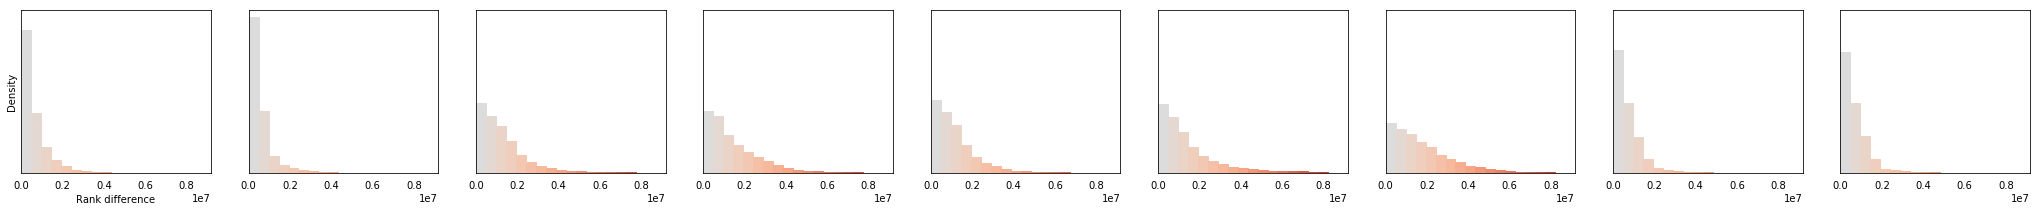

In [17]:
fig_5, axes = plt.subplots(ncols=len(projection_paths), nrows=1, sharey=True, sharex=True, figsize=(len(projection_paths)*4, 3))
axes = axes.flatten()
n_bins = 19
bins = np.linspace(min_diff, max_diff, n_bins+1)
axes[0].set_xlim((0, max_diff))
axes[0].set_ylabel(' ')
for i, p in enumerate(projection_paths):
    ax = axes[i]
    if i == 0:
        ax.set_xlabel('Rank difference')
        ax.set_ylabel('Density')
        
    n, _, patches = ax.hist(diffs[p], bins=bins, density=1)    
    bin_avgs = [(a+b)/2 for a, b in zip(bins, bins[1:])]
#     norm = Normalize(vmin=min_diff, vmax=max_diff)
    cs = cm.coolwarm(np.linspace(0.5,1,n_bins))
    [p.set_color(c) for p, c in zip(patches,cs)]
    
    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                   labelbottom=True, right=False, left=False, labelleft=False)
fig_5.savefig('fig_5.png', bbox_inches='tight', pad_inches=0.1)

In [18]:
import cv2
# os.chdir('..')
im_1 = cv2.imread('fig_1.png')
im_2 = cv2.imread('fig_2.png')
im_3 = cv2.imread('fig_3.png')
im_4 = cv2.imread('fig_4.png')
im_5 = cv2.imread('fig_5.png')

In [19]:
max_width = max([i.shape[1] for i in [im_1, im_2, im_3, im_4, im_5]])

In [20]:
im = np.concatenate([
    np.concatenate([(np.ones((im_1.shape[0], max_width - im_1.shape[1], 3)) * 255), im_1], axis=1),
    np.concatenate([(np.ones((im_4.shape[0], max_width - im_4.shape[1], 3)) * 255), im_4], axis=1),
    np.concatenate([(np.ones((im_5.shape[0], max_width - im_5.shape[1], 3)) * 255), im_5], axis=1),
    np.concatenate([(np.ones((im_3.shape[0], max_width - im_3.shape[1], 3)) * 255), im_3], axis=1),
    np.concatenate([(np.ones((im_2.shape[0], max_width - im_2.shape[1], 3)) * 255), im_2], axis=1)], axis=0)
cv2.imwrite('Plots/Figs/trails-{}.png'.format(dataset_id), im)

True

In [21]:
! rm fig_1.png
! rm fig_2.png
! rm fig_3.png
! rm fig_4.png
! rm fig_5.png